In [25]:
import os
import argparse
import glob
from PIL import Image
import numpy as np
import matplotlib

import matplotlib.pyplot as plt
from sklearn.datasets import make_circles
import torch
import torch.nn as nn
import torch.optim as optim

from typing import Union, Callable
from torch.autograd import grad

In [26]:
import seaborn as sns

In [65]:
parser = argparse.ArgumentParser()
parser.add_argument('--adjoint', action='store_false')
parser.add_argument('--viz', action='store_true')
parser.add_argument('--niters', type=int, default=1000)
parser.add_argument('--lr', type=float, default=1e-3)
parser.add_argument('--num_samples', type=int, default=512)
parser.add_argument('--width', type=int, default=32)
parser.add_argument('--hidden_dim', type=int, default=2)
parser.add_argument('--gpu', type=int, default=0)
parser.add_argument('--train_dir', type=str, default=None)
parser.add_argument('--results_dir', type=str, default="./results_toy_2d")
parser.add_argument('--problem_dim', type=int, default=1)
parser.add_argument('--run_model', type=bool, default=True)
args = parser.parse_args(args=())

In [28]:
plt.rc("axes.spines", right=True, top=True)
plt.rc("figure", dpi=300, 
       figsize=(9, 3)
      )
plt.rc("font", family="serif")
plt.rc("legend", edgecolor="none", frameon=True)

In [29]:
if args.adjoint:
    from torchdiffeq import odeint_adjoint as odeint
else:
    from torchdiffeq import odeint

In [30]:
device = torch.device('cuda:' + str(args.gpu)
                          if torch.cuda.is_available() else 'cpu')
device

device(type='cpu')

In [31]:
def autograd_trace(x_out, x_in, **kwargs):
    """Standard brute-force means of obtaining trace of the Jacobian, O(d) calls to autograd"""
    trJ = 0.
    for i in range(x_in.shape[1]):
        trJ += grad(x_out[:, i].sum(), x_in, allow_unused=False, create_graph=True)[0][:, i]
    return trJ

def hutch_trace(x_out, x_in, noise=None, **kwargs):
    """Hutchinson's trace Jacobian estimator, O(1) call to autograd"""
    jvp = grad(x_out, x_in, noise, create_graph=True)[0]
    trJ = torch.einsum('bi,bi->b', jvp, noise)

    return trJ

In [32]:
class CNF(nn.Module):
    """Adapted from the NumPy implementation at:
    https://gist.github.com/rtqichen/91924063aa4cc95e7ef30b3a5491cc52
    """
    def __init__(self, in_out_dim, hidden_dim, width):
        super().__init__()
        self.in_out_dim = in_out_dim
        self.hidden_dim = hidden_dim
        self.width = width
        self.hyper_net = HyperNetwork(in_out_dim, hidden_dim, width)

    def forward(self, t, states):
        z = states[0]
        logp_z = states[1]

        batchsize = z.shape[0]

        with torch.set_grad_enabled(True):
            z.requires_grad_(True)

            W, B, U = self.hyper_net(t)

            Z = torch.unsqueeze(z, 0).repeat(self.width, 1, 1)

            h = torch.tanh(torch.matmul(Z, W) + B)
            dz_dt = torch.matmul(h, U).mean(0)

            dlogp_z_dt = -trace_df_dz(dz_dt, z).view(batchsize, 1)

        return (dz_dt, dlogp_z_dt)


def trace_df_dz(f, z):
    """Calculates the trace of the Jacobian df/dz.
    Stolen from: https://github.com/rtqichen/ffjord/blob/master/lib/layers/odefunc.py#L13
    """
    sum_diag = 0.
    for i in range(z.shape[1]):
        sum_diag += torch.autograd.grad(f[:, i].sum(), z, create_graph=True)[0].contiguous()[:, i].contiguous()

    return sum_diag.contiguous()


class HyperNetwork(nn.Module):
    """Hyper-network allowing f(z(t), t) to change with time.

    Adapted from the NumPy implementation at:
    https://gist.github.com/rtqichen/91924063aa4cc95e7ef30b3a5491cc52
    """
    def __init__(self, in_out_dim, hidden_dim, width):
        super().__init__()

        blocksize = width * in_out_dim

        self.fc1 = nn.Linear(1, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, hidden_dim)
        self.fc3 = nn.Linear(hidden_dim, 3 * blocksize + width)

        self.in_out_dim = in_out_dim
        self.hidden_dim = hidden_dim
        self.width = width
        self.blocksize = blocksize

    def forward(self, t):
        # predict params
        params = t.reshape(1, 1)
        params = torch.tanh(self.fc1(params))
        params = torch.tanh(self.fc2(params))
        params = self.fc3(params)

        # restructure
        params = params.reshape(-1)
        W = params[:self.blocksize].reshape(self.width, self.in_out_dim, 1)

        U = params[self.blocksize:2 * self.blocksize].reshape(self.width, 1, self.in_out_dim)

        G = params[2 * self.blocksize:3 * self.blocksize].reshape(self.width, 1, self.in_out_dim)
        U = U * torch.sigmoid(G)

        B = params[3 * self.blocksize:].reshape(self.width, 1, 1)
        return [W, B, U]
    
    


In [33]:
def get_batch(num_samples, problem_dim):
    if problem_dim == 2:
        points, _ = make_circles(n_samples=num_samples, noise=0.06, factor=0.5)
        x = torch.tensor(points).type(torch.float32).to(device)
        logp_diff_t1 = torch.zeros(num_samples, 1).type(torch.float32).to(device)
        return(x, logp_diff_t1)
    elif problem_dim == 1:
        # Define the mean of each gaussian
        means = np.array([-3.5, 0.0, 3.5])
        # Define the weights for each gaussian
        weights = np.array([0.2, 0.2, 0.6])
        weights /= np.sum(weights)
        # randomly choose a gaussian for each sample
        components = np.random.choice(means.size, size=num_samples, p=weights)
        # sample from the chosen gaussians
        points = np.random.normal(means[components], 1, size=num_samples)
        return torch.from_numpy(points).float().view(-1, 1).to(device), torch.zeros(num_samples, 1).type(torch.float32).to(device)        

In [34]:
# pts, difft1 = get_batch_2(2000)
# sns.histplot(pts, kde=True)

In [35]:
t0 = 0
t1 = 1

In [36]:
if args.problem_dim == 1:
    p_z0 = torch.distributions.Normal(
    loc=torch.tensor(0.0).to(device),
    scale=torch.tensor(1.0).to(device)
        )
    
#     x, logp_diff_t1 = get_batch_2(args.num_samples)
else:
    p_z0 = torch.distributions.MultivariateNormal(
        loc=torch.tensor([0.0, 0.0]).to(device),
        covariance_matrix=torch.tensor([[0.1, 0.0], [0.0, 0.1]]).to(device)
        )
#     x, logp_diff_t1 = get_batch(args.num_samples)

In [37]:
func = CNF(in_out_dim=args.problem_dim, hidden_dim=args.hidden_dim, width=args.width).to(device)
optimizer = optim.Adam(func.parameters(), lr=args.lr)

In [38]:
# z_t, logp_diff_t = odeint(
#                 func,
#                 (x, logp_diff_t1),
#                 torch.tensor([t1, t0]).type(torch.float32).to(device),
#                 atol=1e-5,
#                 rtol=1e-5,
#                 method='dopri5',
#             )

In [39]:
# z_t0, logp_diff_t0 = z_t[-1], logp_diff_t[-1]

# if args.problem_dim == 1:
#     logp_x = p_z0.log_prob(z_t0).to(device).view(-1) - logp_diff_t0.view(-1)
# else:
#     logp_x = p_z0.log_prob(z_t0).to(device) - logp_diff_t0.view(-1)

In [40]:
# p_z0.log_prob(z_t0).shape

In [41]:
# z_t0.shape # 512, 2

In [42]:
# logp_diff_t0.shape # 512, 1

In [43]:
# logp_diff_t0.view(-1).shape # 512

In [44]:
# logp_x.shape # 512

In [45]:
# loss = -logp_x.mean(0) # single value tensor

In [46]:
# loss

In [47]:
if args.run_model:
    for itr in range(1, args.niters + 1):
        optimizer.zero_grad()

        x, logp_diff_t1 = get_batch(args.num_samples, args.problem_dim)

        z_t, logp_diff_t = odeint(
            func,
            (x, logp_diff_t1),
            torch.tensor([t1, t0]).type(torch.float32).to(device),
            atol=1e-5,
            rtol=1e-5,
            method='dopri5',
        )

        z_t0, logp_diff_t0 = z_t[-1], logp_diff_t[-1]

        if args.problem_dim == 1:
            logp_x = p_z0.log_prob(z_t0).to(device).view(-1) - logp_diff_t0.view(-1)
        else:
            logp_x = p_z0.log_prob(z_t0).to(device) - logp_diff_t0.view(-1)

        loss = -logp_x.mean(0)

        loss.backward()
        optimizer.step()

        #     loss_meter.update(loss.item())

        #     print('Iter: {}, running avg loss: {:.4f}'.format(itr, loss_meter.avg))
        print('Iter: {}, running avg loss: {:.4f}'.format(itr, loss.item()))
    #     torch.save(func, "./cnf_torchdiffeq_toy_1d_gaussian.pt")
else:
    sd = torch.load("./cnf_torchdiffeq_toy_1d_gaussian.pt")
    func = CNF(in_out_dim=args.problem_dim, hidden_dim=args.hidden_dim, width=args.width).to(device)
    func.load_state_dict(sd)
    #     func.eval()

Iter: 1, running avg loss: 6.6743
Iter: 2, running avg loss: 5.8909
Iter: 3, running avg loss: 6.1317
Iter: 4, running avg loss: 6.1907
Iter: 5, running avg loss: 6.2790
Iter: 6, running avg loss: 6.2825
Iter: 7, running avg loss: 6.1386
Iter: 8, running avg loss: 6.4528
Iter: 9, running avg loss: 6.0516
Iter: 10, running avg loss: 6.3642
Iter: 11, running avg loss: 6.0396
Iter: 12, running avg loss: 6.0759
Iter: 13, running avg loss: 6.3057
Iter: 14, running avg loss: 6.2916
Iter: 15, running avg loss: 6.2349
Iter: 16, running avg loss: 6.1105
Iter: 17, running avg loss: 6.2316
Iter: 18, running avg loss: 6.1859
Iter: 19, running avg loss: 5.8935
Iter: 20, running avg loss: 6.0192
Iter: 21, running avg loss: 6.0834
Iter: 22, running avg loss: 5.9731
Iter: 23, running avg loss: 6.1564
Iter: 24, running avg loss: 6.4684
Iter: 25, running avg loss: 6.0148
Iter: 26, running avg loss: 6.1654
Iter: 27, running avg loss: 5.8691
Iter: 28, running avg loss: 5.8904
Iter: 29, running avg loss: 6

Iter: 232, running avg loss: 4.4646
Iter: 233, running avg loss: 4.7456
Iter: 234, running avg loss: 4.4738
Iter: 235, running avg loss: 4.6891
Iter: 236, running avg loss: 4.6998
Iter: 237, running avg loss: 4.7759
Iter: 238, running avg loss: 4.4093
Iter: 239, running avg loss: 4.6746
Iter: 240, running avg loss: 4.5578
Iter: 241, running avg loss: 4.6172
Iter: 242, running avg loss: 4.6982
Iter: 243, running avg loss: 4.8267
Iter: 244, running avg loss: 4.4788
Iter: 245, running avg loss: 4.4662
Iter: 246, running avg loss: 4.4954
Iter: 247, running avg loss: 4.3092
Iter: 248, running avg loss: 4.3496
Iter: 249, running avg loss: 4.5222
Iter: 250, running avg loss: 4.6454
Iter: 251, running avg loss: 4.2777
Iter: 252, running avg loss: 4.2907
Iter: 253, running avg loss: 4.3936
Iter: 254, running avg loss: 4.5902
Iter: 255, running avg loss: 4.8066
Iter: 256, running avg loss: 4.5828
Iter: 257, running avg loss: 4.4765
Iter: 258, running avg loss: 4.3085
Iter: 259, running avg loss:

Iter: 463, running avg loss: 3.1731
Iter: 464, running avg loss: 3.1265
Iter: 465, running avg loss: 3.1227
Iter: 466, running avg loss: 3.1455
Iter: 467, running avg loss: 3.1155
Iter: 468, running avg loss: 3.0601
Iter: 469, running avg loss: 3.1230
Iter: 470, running avg loss: 3.0844
Iter: 471, running avg loss: 3.1549
Iter: 472, running avg loss: 3.0128
Iter: 473, running avg loss: 3.1044
Iter: 474, running avg loss: 3.0854
Iter: 475, running avg loss: 2.9865
Iter: 476, running avg loss: 3.1169
Iter: 477, running avg loss: 3.0185
Iter: 478, running avg loss: 3.0038
Iter: 479, running avg loss: 3.0867
Iter: 480, running avg loss: 2.9526
Iter: 481, running avg loss: 3.0638
Iter: 482, running avg loss: 3.0939
Iter: 483, running avg loss: 3.0381
Iter: 484, running avg loss: 3.0919
Iter: 485, running avg loss: 3.0342
Iter: 486, running avg loss: 3.1892
Iter: 487, running avg loss: 3.0531
Iter: 488, running avg loss: 2.9786
Iter: 489, running avg loss: 3.0712
Iter: 490, running avg loss:

Iter: 691, running avg loss: 2.4724
Iter: 692, running avg loss: 2.5075
Iter: 693, running avg loss: 2.4850
Iter: 694, running avg loss: 2.5404
Iter: 695, running avg loss: 2.5213
Iter: 696, running avg loss: 2.5234
Iter: 697, running avg loss: 2.4804
Iter: 698, running avg loss: 2.5621
Iter: 699, running avg loss: 2.5563
Iter: 700, running avg loss: 2.4539
Iter: 701, running avg loss: 2.5493
Iter: 702, running avg loss: 2.5070
Iter: 703, running avg loss: 2.5866
Iter: 704, running avg loss: 2.4996
Iter: 705, running avg loss: 2.4528
Iter: 706, running avg loss: 2.5169
Iter: 707, running avg loss: 2.5016
Iter: 708, running avg loss: 2.5116
Iter: 709, running avg loss: 2.4494
Iter: 710, running avg loss: 2.5435
Iter: 711, running avg loss: 2.5123
Iter: 712, running avg loss: 2.5550
Iter: 713, running avg loss: 2.4995
Iter: 714, running avg loss: 2.4431
Iter: 715, running avg loss: 2.5525
Iter: 716, running avg loss: 2.5130
Iter: 717, running avg loss: 2.5175
Iter: 718, running avg loss:

Iter: 919, running avg loss: 2.2811
Iter: 920, running avg loss: 2.3249
Iter: 921, running avg loss: 2.3392
Iter: 922, running avg loss: 2.2850
Iter: 923, running avg loss: 2.3257
Iter: 924, running avg loss: 2.3461
Iter: 925, running avg loss: 2.3653
Iter: 926, running avg loss: 2.3302
Iter: 927, running avg loss: 2.3127
Iter: 928, running avg loss: 2.3139
Iter: 929, running avg loss: 2.3519
Iter: 930, running avg loss: 2.3273
Iter: 931, running avg loss: 2.3789
Iter: 932, running avg loss: 2.2799
Iter: 933, running avg loss: 2.3038
Iter: 934, running avg loss: 2.3559
Iter: 935, running avg loss: 2.3439
Iter: 936, running avg loss: 2.3030
Iter: 937, running avg loss: 2.2857
Iter: 938, running avg loss: 2.3792
Iter: 939, running avg loss: 2.2756
Iter: 940, running avg loss: 2.2701
Iter: 941, running avg loss: 2.3293
Iter: 942, running avg loss: 2.2681
Iter: 943, running avg loss: 2.3577
Iter: 944, running avg loss: 2.3210
Iter: 945, running avg loss: 2.2690
Iter: 946, running avg loss:

In [50]:
func

CNF(
  (hyper_net): HyperNetwork(
    (fc1): Linear(in_features=1, out_features=2, bias=True)
    (fc2): Linear(in_features=2, out_features=2, bias=True)
    (fc3): Linear(in_features=2, out_features=128, bias=True)
  )
)

In [56]:
xfinal, logp_diff_t1_final = get_batch(1000, args.problem_dim)

In [57]:
z_t_final, logp_diff_t_final = odeint(
            func,
            (xfinal, logp_diff_t1_final),
            #             torch.tensor(np.linspace(t1, t0, 50)).type(torch.float32).to(device),
            torch.tensor([t1, t0]).type(torch.float32).to(device),
            atol=1e-5,
            rtol=1e-5,
            method='dopri5',
        )

In [58]:
z_t_final.shape

torch.Size([2, 1000, 1])

In [63]:
actual_samples = p_z0.sample_n(1000).detach().numpy()

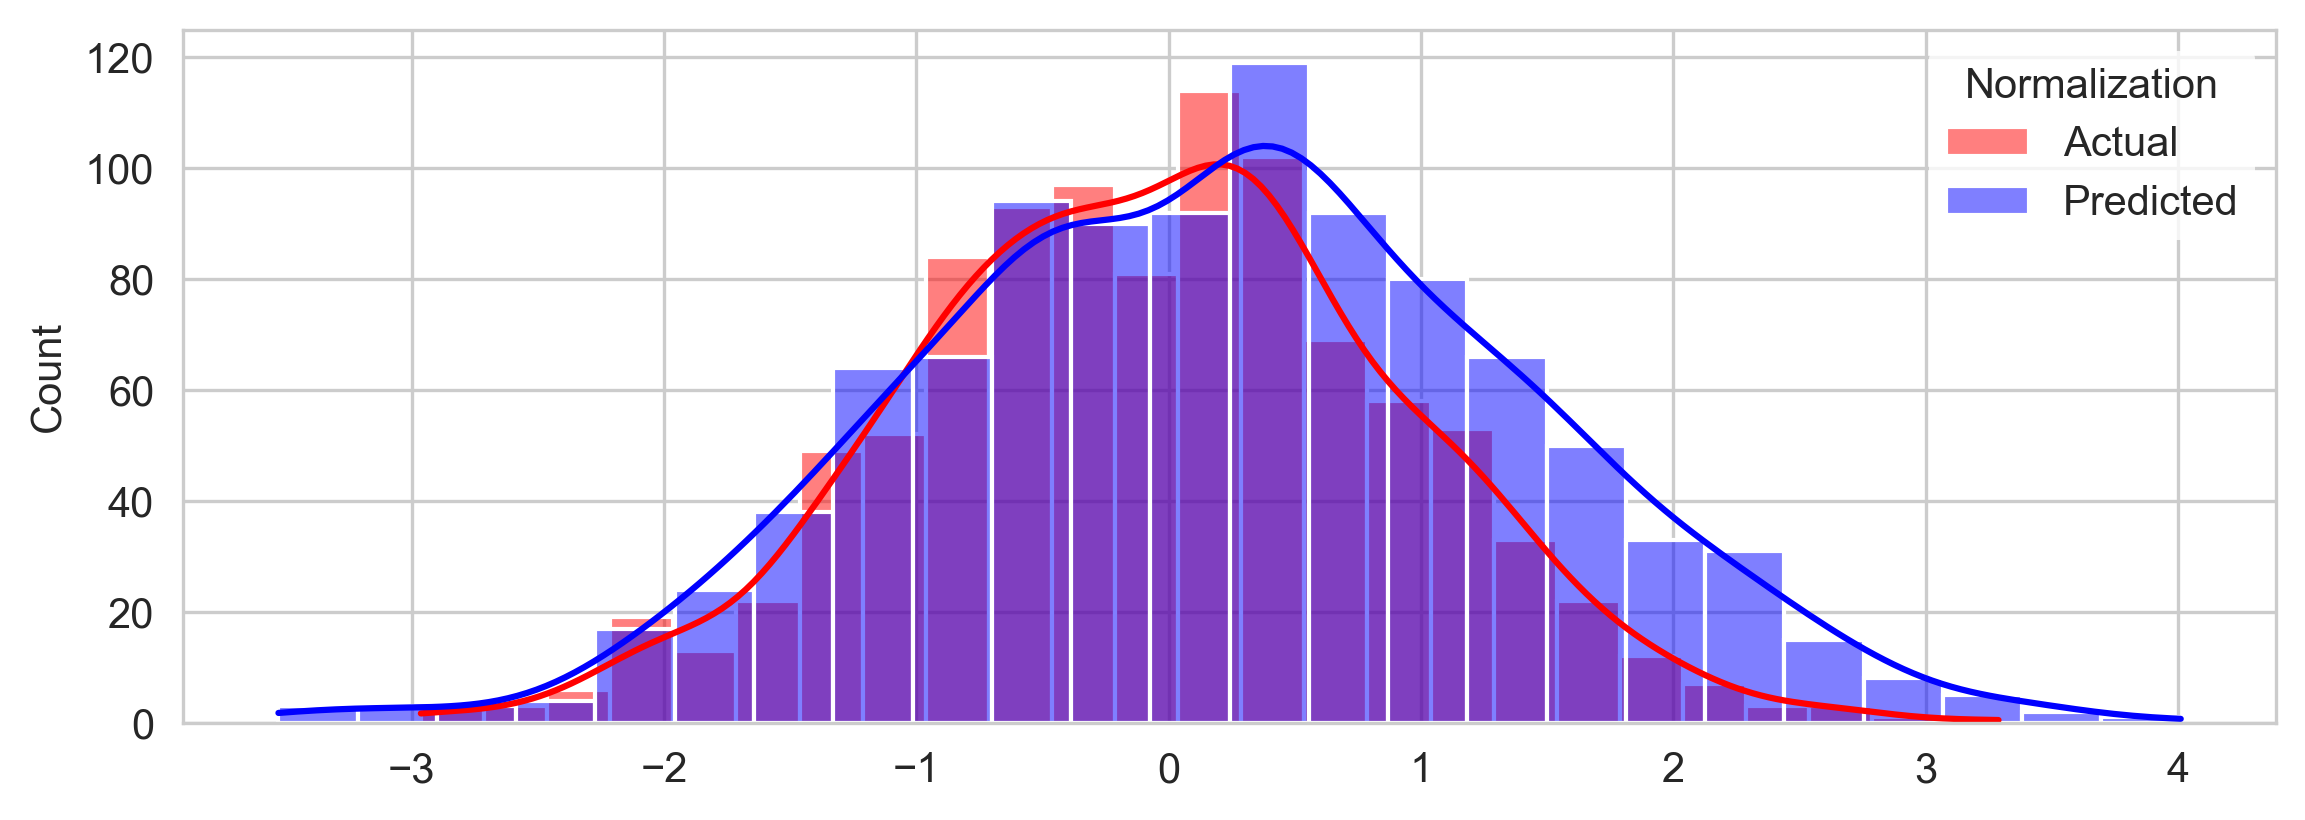

In [64]:
sns.set_style("whitegrid")

sns.histplot(actual_samples, kde=True, color="red", label="Actual")
sns.histplot(z_t_final.detach().numpy()[1, :, 0], kde=True, color="blue", label="Predicted")

plt.legend(title="Normalization")

In [54]:
# sns.set_style("whitegrid")
# fig = plt.figure(figsize=(6, 6))

# ax=fig.add_subplot()
# ax.plot(np.linspace(t1, t0, 50), z_t_final[:, :, 0].detach().cpu().numpy())
# ax.set_xlabel("t")
# ax.set_ylabel("z")

In [ ]:
# Generate some data
import matplotlib.cm as cm
x = np.linspace(0, 10, 1000)
y = np.sin(x)

# Create a colormap
c = cm.jet((y-y.min())/y.ptp())

# Create a scatter plot with a color for each point
sc = plt.scatter(x, y, c=y, cmap='jet', s=10, linewidth=0)

# Add a colorbar
plt.colorbar(sc)

# Connect the points with a line
plt.plot(x, y, color='black', linewidth=0.5, alpha=0.5)

In [55]:
# pts, difft1 = get_batch(2000, args.problem_dim)
# sns.histplot(pts, kde=True)